In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from qucumber.nn_states import ComplexWaveFunction

from qucumber.callbacks import MetricEvaluator

import qucumber.utils.unitaries as unitaries

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

In [5]:
train_path = "w_state_meas.txt"
train_bases_path = "w_state_basis.txt"
psi_path = "w_state_aug.txt"
bases_path = "w_state_bases.txt"

train_samples, true_psi, train_bases, bases = data.load_data(train_path, psi_path, train_bases_path, bases_path)

In [6]:
one_hot_indices = [2**i for i in range(true_psi.shape[1].bit_length() - 1)]
one_hot_true_psi = true_psi[:, one_hot_indices]

true_phases_raw = torch.angle(one_hot_true_psi[0, :] + 1j * one_hot_true_psi[1, :])
true_phases_wrapped = (true_phases_raw - true_phases_raw[0]) % (2 * np.pi)
true_phases_wrapped

tensor([0.0000, 6.2650, 4.9906, 3.2157], dtype=torch.float64)

In [7]:
qucumber.set_random_seed(1234, cpu=True, gpu=False)

# simple dictionary to look up the unitaries for rotation
unitary_dict = unitaries.create_dict()

nv = train_samples.shape[-1]
nh = nv

nn_state = ComplexWaveFunction(
    num_visible=nv, num_hidden=nh, unitary_dict=unitary_dict, gpu=False
)

epochs = 70
pbs = 100  # general batch size
nbs = 100  # num_chains
lr = 1e-1  # learning rate
k = 10
log_every = 5


# metrics to be evaluated every few epochs
space = nn_state.generate_hilbert_space()

callbacks = [
    MetricEvaluator(
        log_every,
        { "Fidelity": ts.fidelity, "KL": ts.KL },
        target=true_psi,
        bases=bases,
        verbose=True,
        space=space,
    )
]

In [8]:
nn_state.fit(
    train_samples,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    input_bases=train_bases,
    callbacks=callbacks,
    time=True,
)

/Users/Tonni/Desktop/master-code/neural-quantum-tomo/case_studies/loss_debugging/experiments/qucumber/utils/data.py:132: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740439190/work/aten/src/ATen/native/IndexingUtils.h:28.)
  z_samples = train_samples[idx]


Epoch: 5	Fidelity = 0.031682	KL = 0.524190
Epoch: 10	Fidelity = 0.050015	KL = 0.490595
Epoch: 15	Fidelity = 0.043003	KL = 0.472258
Epoch: 20	Fidelity = 0.052033	KL = 0.460265
Epoch: 25	Fidelity = 0.052472	KL = 0.449138
Epoch: 30	Fidelity = 0.064044	KL = 0.429191
Epoch: 35	Fidelity = 0.075677	KL = 0.408769
Epoch: 40	Fidelity = 0.085170	KL = 0.389292
Epoch: 45	Fidelity = 0.330260	KL = 0.322576
Epoch: 50	Fidelity = 0.421625	KL = 0.292170
Epoch: 55	Fidelity = 0.673840	KL = 0.233420
Epoch: 60	Fidelity = 0.859016	KL = 0.111054
Epoch: 65	Fidelity = 0.905890	KL = 0.076499
Epoch: 70	Fidelity = 0.903555	KL = 0.092606
Total time elapsed during training: 141.777 s


In [9]:
fidelities = callbacks[0].Fidelity  # access via the attribute
KLs = callbacks[0]["KL"] # access via the dictionary-like interface if name contains special characters
epoch = np.arange(log_every, epochs + 1, log_every)

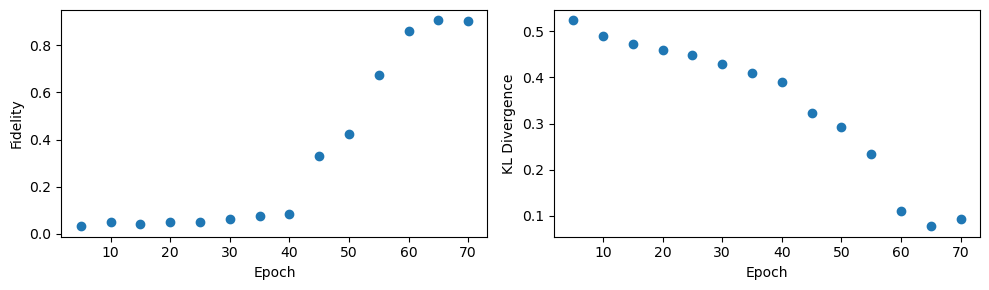

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(epoch, fidelities, 'o')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Fidelity")

axs[1].plot(epoch, KLs, 'o')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("KL Divergence")

plt.tight_layout()
plt.show()

In [11]:
# calculate the phases of the coefficients
full_hilbert_space = nn_state.generate_hilbert_space()
one_hot_hilbert_space = full_hilbert_space[one_hot_indices, :]

pred_phases_raw = nn_state.phase(one_hot_hilbert_space)
pred_phases_wrapped = (pred_phases_raw - pred_phases_raw[0]) % (2 * np.pi)

pred_phases_wrapped

tensor([0.0000, 6.2756, 4.9946, 3.2647], dtype=torch.float64)

In [12]:
true_phases_wrapped

tensor([0.0000, 6.2650, 4.9906, 3.2157], dtype=torch.float64)

In [13]:
one_hot_hilbert_space

tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]], dtype=torch.float64)

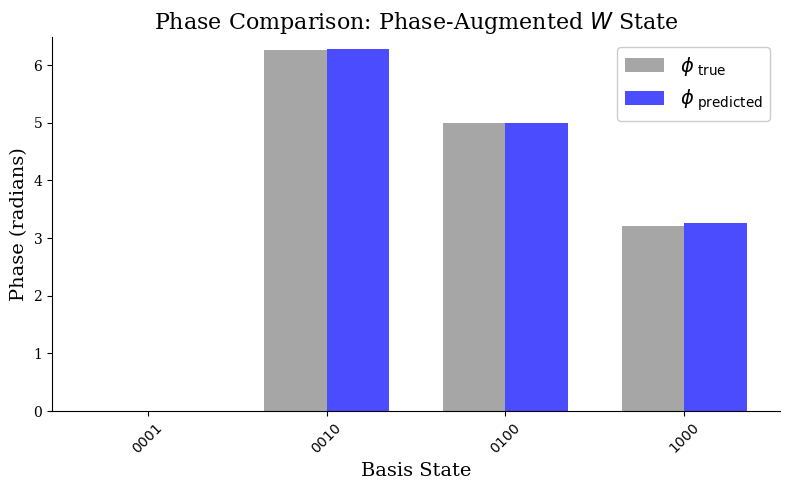

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Configure global plot style
plt.rcParams.update({"font.family": "serif"})

# Setup
bitstrings = ["".join(str(int(b)) for b in row) for row in one_hot_hilbert_space.numpy()]
indices = np.arange(len(pred_phases_wrapped))
width = 0.35

# Create figure
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
ax.set_facecolor('white')

# Bar plots
ax.bar(indices - width/2, true_phases_wrapped, width, alpha=0.7,
       color='gray', label=r'$\phi_{\mathrm{ \ true}}$', zorder=1)
ax.bar(indices + width/2, pred_phases_wrapped, width, alpha=0.7,
       color='blue', label=r'$\phi_{\mathrm{ \ predicted}}$', zorder=2)

# Labels and title
ax.set_xlabel("Basis State", fontsize=14)
ax.set_ylabel("Phase (radians)", fontsize=14)
ax.set_title("Phase Comparison: Phase-Augmented $W$ State", fontsize=16)

# X-ticks and labels
ax.set_xticks(indices)
ax.set_xticklabels([f"${b}$" for b in bitstrings], rotation=45)

# Y-limits
ax.set_ylim(0, 2 * np.pi + 0.2)

# Legend
ax.legend(frameon=True, framealpha=1, loc='best', fontsize=14)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Layout and save
plt.tight_layout()
plt.show()